# Measuring diversity

As important diversity is for cities, as complicated is to capture it. `momepy` offers several options on how to do that using urban morphometrics. Generally, we can distinguish three types of diversity characters, based on:

1. Absolute values
2. Relative values
3. Categorization (binning)

This notebook provides examples from each of them.

In [1]:
import matplotlib.pyplot as plt
import momepy
import osmnx as ox
from libpysal import graph

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. 

In [2]:
gdf = ox.features.features_from_place("Kahla, Germany", tags={"building": True})
buildings = ox.projection.project_gdf(gdf).reset_index(drop=True)

limit = momepy.buffered_limit(buildings)
tess = momepy.morphological_tessellation(buildings, clip=limit)
tessellation = tess.to_frame("geometry")

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/features.py:294: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


### Queen contiguity

Morphological tessellation allows using contiguity-based graphs. While `Graph.build_contiguity` will do the standard Queen contiguity graph of the first order it might not be enough to capture proper context. For that reason, we can use the higher order to capture all neighbours within set topological distance `k`. To consider a geometry a part of its neighborhood, assign self weights. More in [Generating spatial weights](weights_nb.ipynb).

In [33]:
contiguity_k3 = (
    graph.Graph.build_contiguity(tessellation, rook=False)
    .higher_order(k=3, lower_order=True)
    .assign_self_weight()
)
contiguity_k3

<Graph of 3014 nodes and 133928 nonzero edges indexed by
 [0, 1, 2, 3, 4, ...]>

### Range

To measure the range of the values withing all neighbours as captured by `contiguity_k3`, you can use `Graph.describe()`.

In [40]:
summary = contiguity_k3.describe(tessellation.area, statistics=["min", "max"])
tessellation["area_rng"] = summary["max"] - summary["min"]

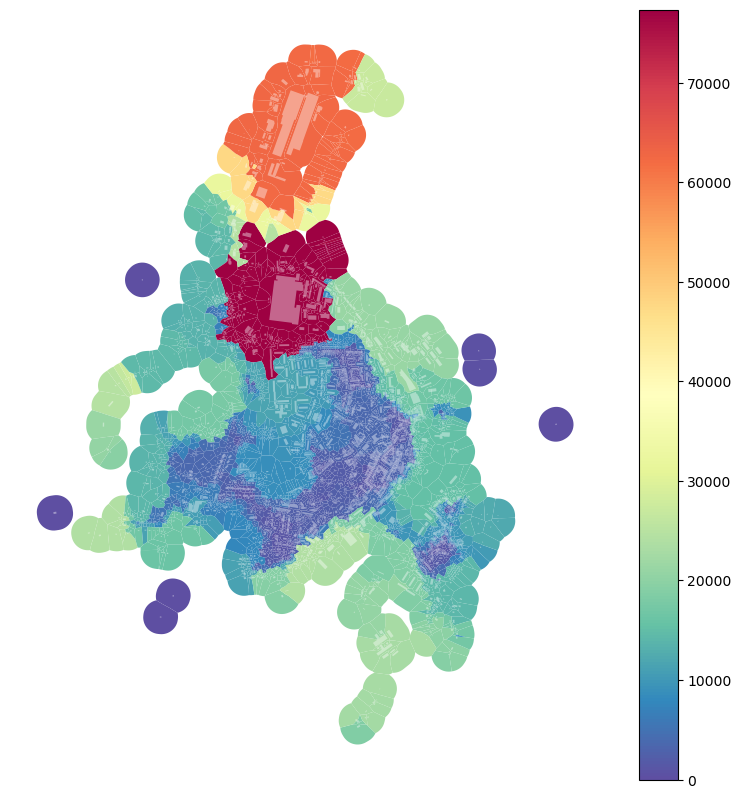

In [41]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column="area_rng", legend=True, cmap="Spectral_r")
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

However, as we can see from the plot above, there is a massive effect of large-scale buildings, which can be seen as outliers. For that reason, we can define `q` keyword argument to limit the range taken into account. To get the interquartile range:

In [42]:
summary = contiguity_k3.describe(
    tessellation.area, statistics=["min", "max"], q=(25, 75)
)
tessellation["area_IQR"] = summary["max"] - summary["min"]

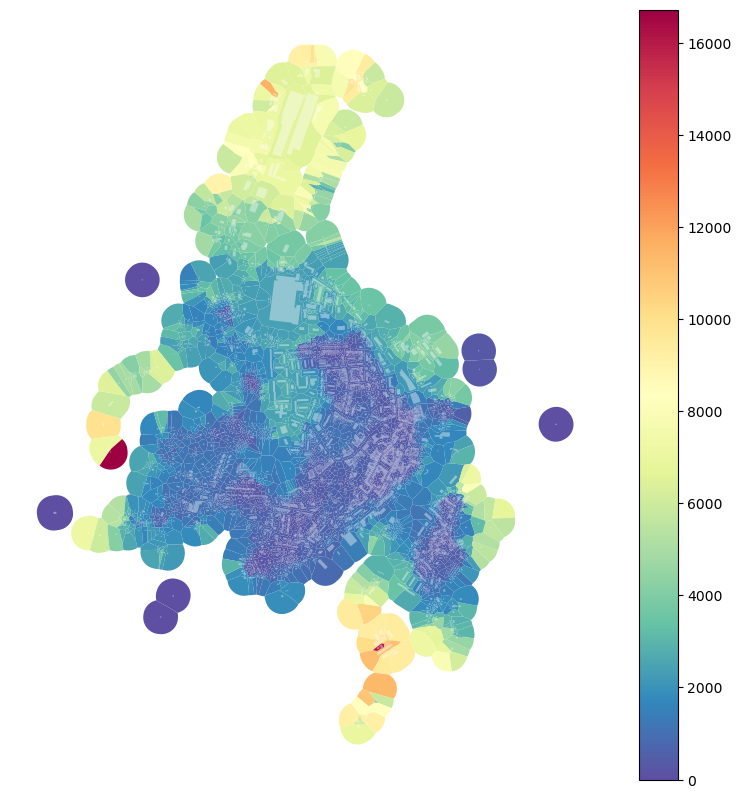

In [43]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column="area_IQR", legend=True, cmap="Spectral_r")
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

The effect of outliers has been successfully eliminated.

### Theil index

Theil index is a measure of inequality (as Gini index is). `momepy` is using `pysal`'s implementation of the Theil index to do the calculation.

In [44]:
tessellation["area_theil"] = momepy.theil(tessellation.area, contiguity_k3)

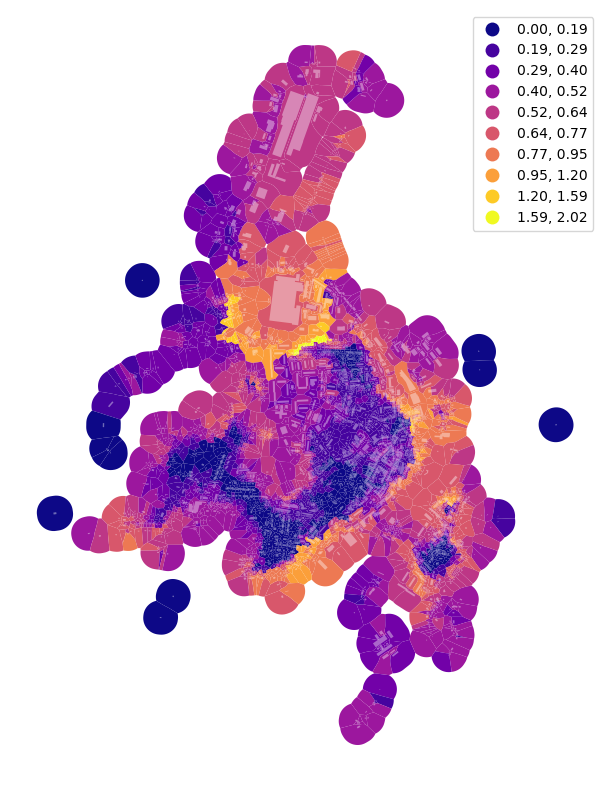

In [45]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax,
    column="area_theil",
    scheme="fisherjenks",
    k=10,
    legend=True,
    cmap="plasma",
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

Again, the outlier effect is present. We can use the same keyword as above to limit it and measure the Theil index on the inter-decile range.

In [46]:
tessellation["area_theil_id"] = momepy.theil(
    tessellation.area, contiguity_k3, q=(10, 90)
)

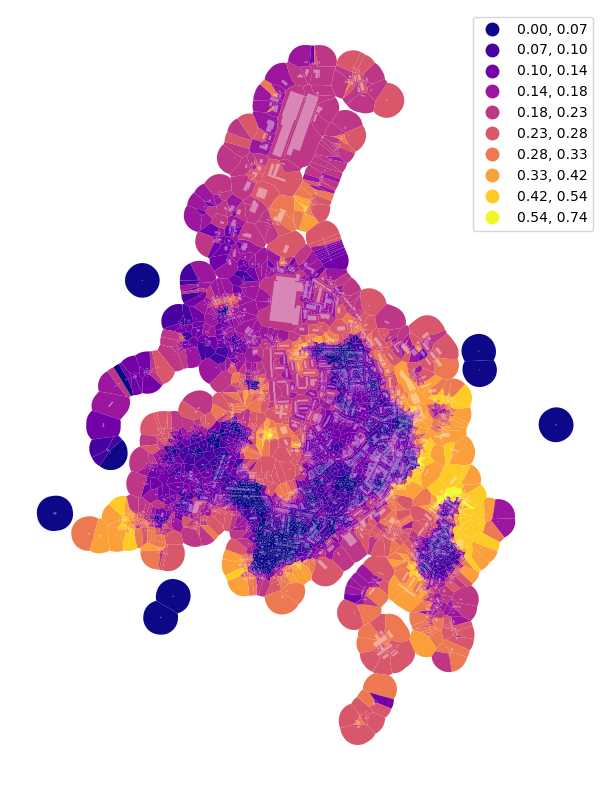

In [47]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax,
    column="area_theil_id",
    scheme="fisherjenks",
    k=10,
    legend=True,
    cmap="plasma",
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

### Simpson's diversity index

Simpson's diversity index is one of the most used indices capturing diversity. However, we need to be careful using it for continuous values, as it depends on the binning of these values to categories. The effect of different binning could be significant. `momepy` uses Head/tail Breaks as a large number of morphometric characters follows power-law distribution (for which Head/tail Breaks are designed). However, you can use any binning provided by `mapclassify` (including user-defined). The default Head/tail Breaks:

In [48]:
tessellation["area_simpson"] = momepy.simpson(tessellation.area, contiguity_k3)

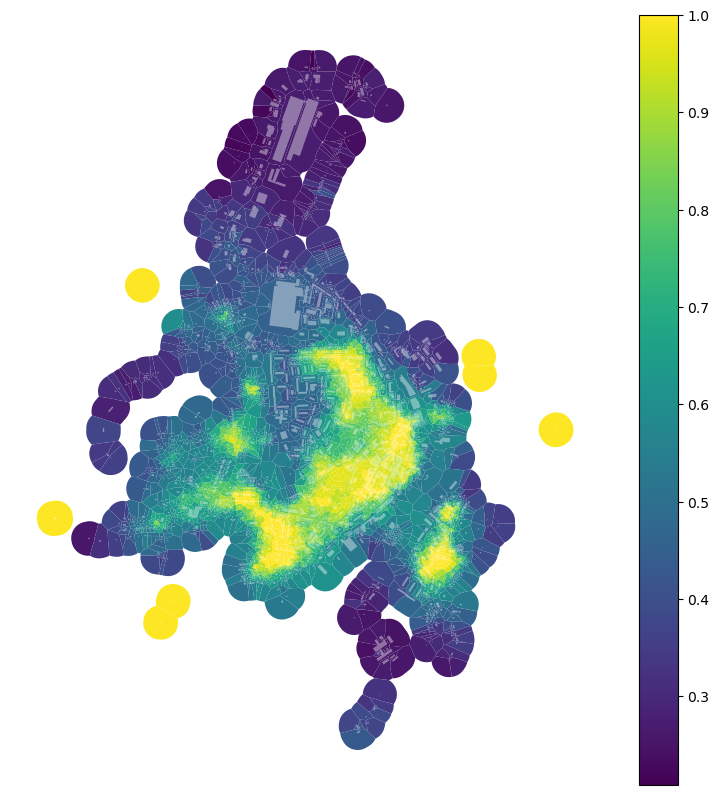

In [49]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column="area_simpson", legend=True, cmap="viridis")
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

And binning based on quantiles (into 7 bins of equal size):

In [50]:
tessellation["area_simpson_q7"] = momepy.simpson(
    tessellation.area,
    contiguity_k3,
    binning="quantiles",
    k=7,
)

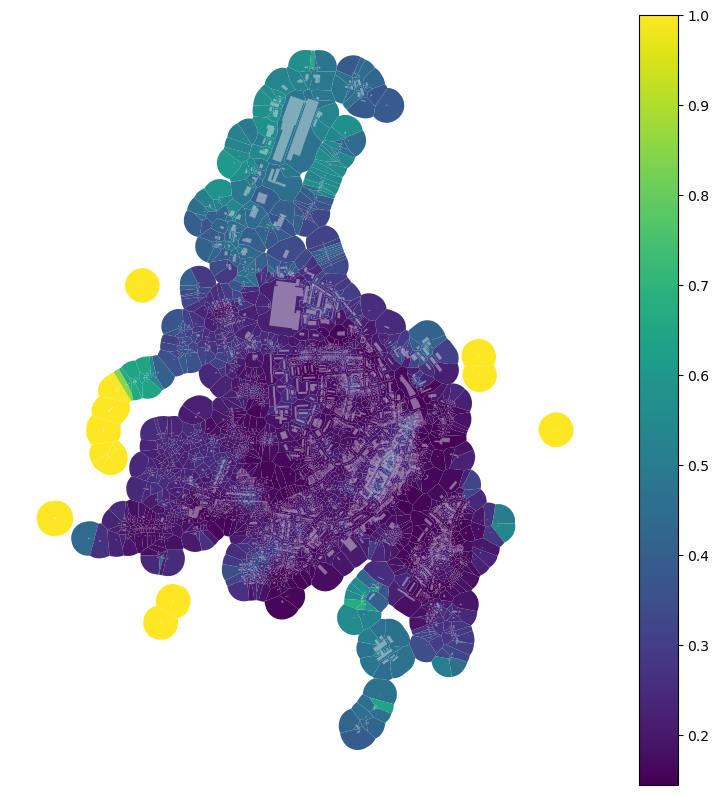

In [51]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column="area_simpson_q7", legend=True, cmap="viridis")
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

Always consider whether your binning is the optimal one.